In [1]:
import sys
import os
sys.path.append("../../../../src/")
#Imports
import single_particle_sector as sps
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter

In [ ]:
#Define Parameters
J = 1
L = 60
h_i = np.linspace(0,2,100)
ns = [i for i in range(1,11)]

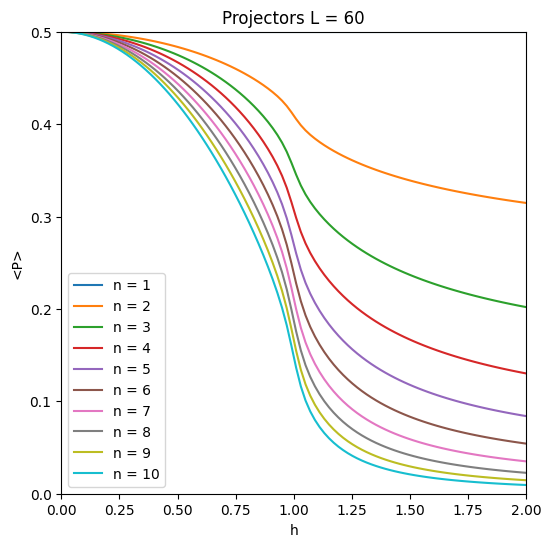

In [ ]:
dat = []
for n in ns:
    dat_n = []
    for h in h_i:
        H = sps.H_bdg(h,L,J,"ABC")
        E,V = la.eigh(H)
        #The only sublety is this step
        #G_TFIM chooses ((1 0),(0 0 )) correlation structure (Ground states only)
        G = sps.G_tfim(V[:,L:])
        dat_n.append(sps.P_n(n,G,L))

    dat.append(np.array(dat_n))
l = 1
plt.figure(figsize=(6,6))

for d in dat:
    plot(h_i,d,label = f"n = {l}")
    l+=1
plt.legend()
plt.xlim(h_i[0],h_i[-1])
plt.ylim(0,.5)
plt.title(f"Projectors L = {L}")
plt.xlabel("h")
plt.ylabel("<P>")
plt.show()

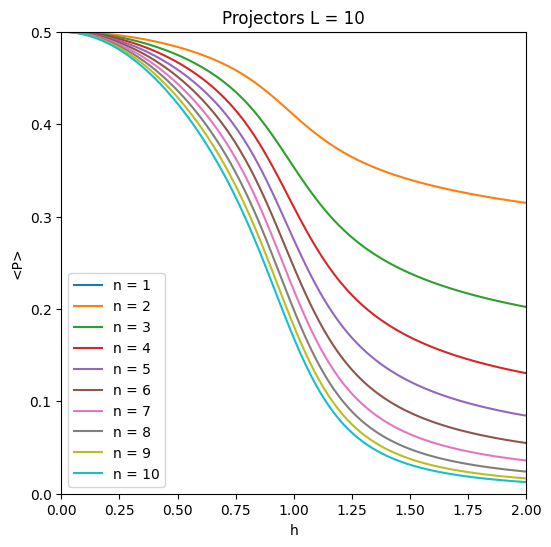

In [ ]:
L = 10
dat2 = []
for n in ns:
    dat_n = []
    for h in h_i:
        H = sps.H_bdg(h,L,J,"ABC")
        E,V = la.eigh(H)
        G = sps.G_tfim(V[:,L:])
        dat_n.append(sps.P_n(n,G,L))

    dat2.append(np.array(dat_n))
l = 1
plt.figure(figsize=(6,6))

for d in dat2:
    plot(h_i,d,label = f"n = {l}")
    l+=1
plt.legend()
plt.xlim(h_i[0],h_i[-1])
plt.ylim(0,.5)
plt.title(f"Projectors L = {L}")
plt.xlabel("h")
plt.ylabel("<P>")
plt.show()

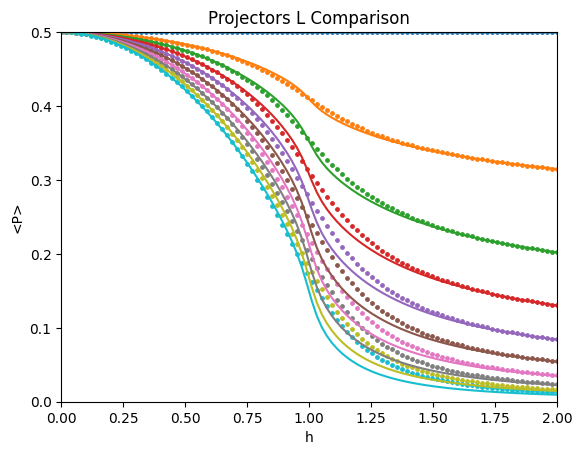

In [ ]:
for d in range(len(dat2)):
    plot(h_i,dat[d],label = f"n = {l}")
    scatter(h_i,dat2[d],label=f"L={L}",s = 6)
    l+=1
#plt.legend()
plt.xlim(h_i[0],h_i[-1])
plt.ylim(0,.5)
plt.title(f"Projectors L Comparison")
plt.xlabel("h")
plt.ylabel("<P>")
plt.show()

# Comparison to ED

In [ ]:
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from itertools import combinations
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time

In [ ]:
def fin_string(ns,s): #ns = length of string s = operator
    #Max string length
    if ns>L:
        ns=L
    else:
        pass
    
    
    def linears(start,m):
        #Find all indices in string
        ind=[i%L for i in range(start,start+ns)]
     #All combinations
        perm=list(combinations(ind,m))
      #Add each coupling to operator
        for j in range(len(perm)):
#            S_temp=[((-1)**m)*(2**m)/(L*(2**ns))] ########### Down #
            S_temp=[1/(L*(2**ns))] ###################### Up
            for i in range(len(perm[j])):
                S_temp.append(perm[j][i])
        ##Saving Couplin gs lists
            if j==0: 
                S_temp_2=[S_temp]
            else: 
                S_temp_2.append(S_temp)
        return S_temp_2
    #List to store orders of interaction
    o_type=np.empty(ns,dtype=object)
    
    for i in range(ns):
        #ex: "z"*2= "zz"
        o_type[i]=s*(i+1)

    #Iterate over each Site
    for k in range(L):
        #Iterate over different string lengths
      for i in range(ns):
          #First item defines list
          if k==0 and i==0:
              #example: i = 0 operator_list = [['x', linears(k,1)]]
              operator_list=[[o_type[i],linears(k,i+1)]]
          else:
              operator_list.append([o_type[i],linears(k,i+1)])
    S_temp_1 = [[(1/((ns*2**ns))), i] for i in range(ns)]
    #S_temp_1 = [[(1/((ns*2**(ns)))), 1] ]
    operator_list.append(["I",S_temp_1])
    operator_dict=dict(S=operator_list)
    O = quantum_operator(operator_dict,basis=basis,check_symm=False,check_herm=False)
    return O, operator_list

In [ ]:
###### Model parameters

#Length of chain
L = 10
J1 = 1 #NN term 
J2 = 0 #NNN Term
h_i = np.linspace(0,2,100)
op = "x"
#Full vs Even(?)
basis = spin_basis_1d(L, pauli = -1)


In [ ]:
#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Define Parameters
params_dict = dict( H0=1, Quench=0)
#Build H0
H0 = H.tohamiltonian(params_dict);
#Find eigenvalues
E,V = np.linalg.eigh(H0.todense())
#Convert matrix to array
V = np.array(V)
#Ground state of unquenched hamiltonian
V0= V[:,0]
D = len(V0)



In [ ]:
#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]

In [ ]:
#Expectations of Projections (Sanity Checks)
Expt_Pi =[]
intial_state_overlap=[]
for hi in h_i:
    params_dict = dict(H0=1, Quench=hi)
    Hi = H.tohamiltonian(params_dict)
    E,V = np.linalg.eigh(Hi.todense())

    V = np.array(V)

    #Ground state
    Vi = V[:,0]

    expectations = [P.expt_value(Vi) for P in Projectors]

    Expt_Pi.append(expectations)
    intial_state_overlap.append(np.abs(V0@Vi)**2)

Expt_Pi = np.array(Expt_Pi)


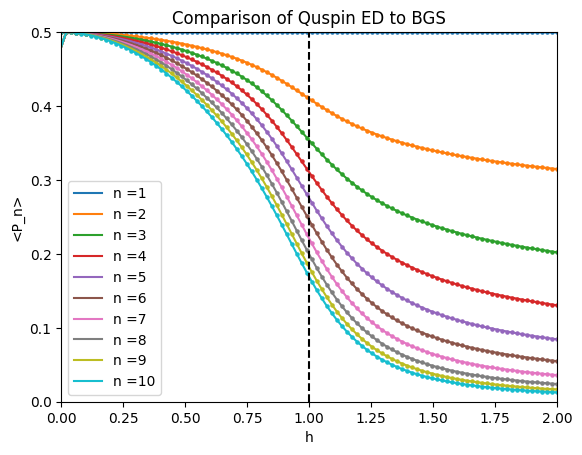

In [ ]:
for n in range(0,L):
    plt.plot(h_i,Expt_Pi[:,n],label="n ="+str(n+1))
    plt.scatter(h_i,dat2[n], s = 5)

plt.legend()
#plt.yscale("log")
plt.ylim(0.0,0.5)
plt.xlim(0,h_i[-1])
plt.xlabel("h")
plt.ylabel("<P_n>")
plt.title("Comparison of Quspin ED to BGS")
plt.plot(figsize=(600,500))
plt.vlines(1,0,1,color="black",linestyle="--")
#plt.savefig("QuspinVsBGS.png")